# Analysis and Optimization

In this code, the predictive model will be created and analyzed.

Afterwards, different optimization methods will be applied and compared, such as Gradient Descent and its variants.

---

### Dataset import

The final dataset is imported to inspect the data.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
from scipy.stats import chi2_contingency, f_oneway
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D

In [2]:
dataset = pd.read_csv("dataset/dataset_final.csv")
print("Number of rows in the dataset:", len(dataset))

pd.set_option('display.max_columns', None)
dataset.head(10)

Number of rows in the dataset: 52160


Driver  LapTime  LapNumber Compound  TyreLife  FreshTyre             Team  \
0    VER   91.295        3.0     SOFT       3.0      False  Red Bull Racing   
1    VER   90.503        8.0     SOFT       2.0       True  Red Bull Racing   
2    VER   89.897       11.0     SOFT       2.0       True  Red Bull Racing   
3    VER   89.708       14.0     SOFT       2.0      False  Red Bull Racing   
4    PER   91.479        3.0     SOFT       3.0      False  Red Bull Racing   
5    PER   90.746        8.0     SOFT       2.0       True  Red Bull Racing   
6    PER   90.131       11.0     SOFT       2.0       True  Red Bull Racing   
7    PER   89.846       14.0     SOFT       2.0      False  Red Bull Racing   
8    LEC   91.094        5.0     SOFT       2.0       True          Ferrari   
9    LEC   91.699       10.0     SOFT       7.0      False          Ferrari   

            EventName     Session  EventYear  AirTemp  Humidity  Pressure  \
0  Bahrain Grand Prix  Qualifying       2023     24.2      16.0    1017.5   
1  Bahrain Grand Prix  Qualifying       2023     23.8      20.0    1017.7   
2  Bahrain Grand Prix  Qualifying       2023     23.1      31.0    1017.7   
3  Bahrain Grand Prix  Qualifying       2023     23.0      33.0    1017.9   
4  Bahrain Grand Prix  Qualifying       2023     24.3      16.0    1017.5   
5  Bahrain Grand Prix  Qualifying       2023     23.8      20.0    1017.7   
6  Bahrain Grand Prix  Qualifying       2023     23.1      31.0    1017.7   
7  Bahrain Grand Prix  Qualifying       2023     23.0      33.0    1017.9   
8  Bahrain Grand Prix  Qualifying       2023     24.2      16.0    1017.5   
9  Bahrain Grand Prix  Qualifying       2023     23.8      20.0    1017.7   

   Rainfall  TrackTemp  WindDirection  WindSpeed  FuelLevel  
0     False       28.7            352        0.6        2.0  
1     False       27.8            342        0.5        2.0  
2     False       26.9            338        1.3        2.0  
3     False       26.6            329        0.8        2.0  
4     False       28.7            333        0.4        2.0  
5     False       27.8            342        0.5        2.0  
6     False       26.9            338        1.3        2.0  
7     False       26.6            329        0.8        2.0  
8     False       28.7            352        0.6        2.0  
9     False       27.8            342        0.5        2.0

In [3]:
dataset.columns

Index(['Driver', 'LapTime', 'LapNumber', 'Compound', 'TyreLife', 'FreshTyre',
       'Team', 'EventName', 'Session', 'EventYear', 'AirTemp', 'Humidity',
       'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed',
       'FuelLevel'],
      dtype='object')

In [4]:
variables = {
    'LapTime': 'Lap time (s)',
    'EventName': 'Track name',
    'Team': 'Team name',
    'Compound': 'Tyre compound',
    'TyreLife': 'Tyre life (laps)',
    'FreshTyre': 'Fresh tyre',
    'FuelLevel': 'Fuel level (kg)',
    'AirTemp': 'Air temperature (°C)',
    'Humidity': 'Humidity (%)',
    'Pressure': 'Air pressure (mbar)',
    'Rainfall': 'Rainfall',
    'TrackTemp': 'Track temperature (°C)',
    'WindDirection': 'Wind direction (°)',
    'WindSpeed': 'Wind speed (m/s)'
}


---

### Correlation Functions

#### 1. Pearson Correlation Coefficient
- Measures the linear association between two **numerical** variables.
- Formula:  
  $$
  r = \frac{ \sum (x_i - \bar{x})(y_i - \bar{y}) }{ \sqrt{ \sum (x_i - \bar{x})^2 } \sqrt{ \sum (y_i - \bar{y})^2 } }
  $$
- Values range from -1 (perfect negative correlation) to 1 (perfect positive correlation).
- A value of 0 indicates no linear correlation.

#### 2. Eta Squared ($\eta^2$)
- Measures the association between a **categorical** variable and a **numerical** variable.
- Formula:  
  $$
  \eta^2 = \frac{SS_{\text{between}}}{SS_{\text{total}}} = \frac{\sum_{g} n_g (\bar{y}_g - \bar{y})^2}{\sum_{i} (y_i - \bar{y})^2}
  $$
- Indicates the proportion of variance in the numerical variable explained by the categorical groups.
- Values range from 0 (no association) to 1 (perfect association).

#### 3. Cramér’s V
- Measures the association between two **categorical** variables.
- Formula:  
  $$
  V = \sqrt{ \frac{ \chi^2 / n }{ \min(k - 1, r - 1) } }
  $$
  where:
  - $\chi^2$ is the chi-squared statistic  
  - $n$ is the sample size  
  - $k$, $r$ are the number of categories in each variable
- Includes bias correction for small or uneven contingency tables.
- Values range from 0 (no association) to 1 (perfect association).

#### Mixed Correlation Matrix
- Computes correlations for all pairs of variables in a dataset with **mixed types**:
  - **Numerical vs Numerical**: Pearson correlation coefficient
  - **Categorical vs Numerical**: Eta squared ($\eta^2$)
  - **Categorical vs Categorical**: Cramér’s V
- Useful for exploratory data analysis on heterogeneous datasets.


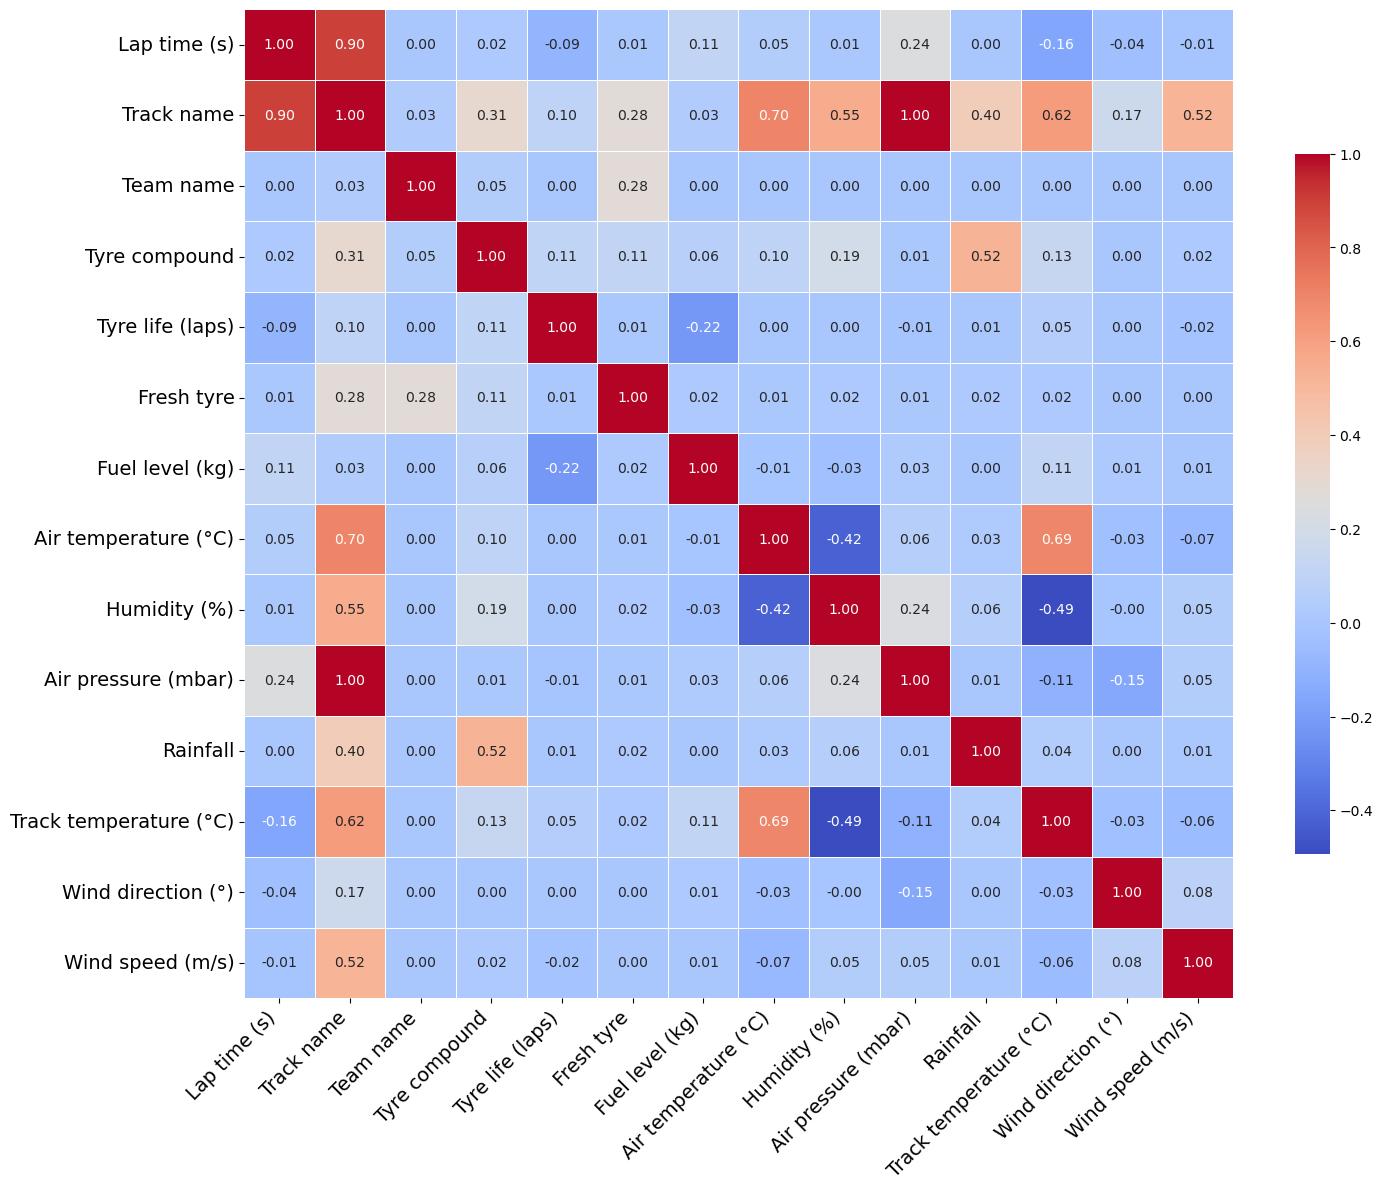

In [5]:
selected_cols = list(variables.keys())
df = dataset[selected_cols].copy()

def eta_squared(cat, num):
    try:
        categories = [num[cat == val] for val in np.unique(cat)]
        ss_between = sum(len(group) * (group.mean() - num.mean()) ** 2 for group in categories)
        ss_total = sum((num - num.mean()) ** 2)
        return ss_between / ss_total if ss_total > 0 else np.nan
    except:
        return np.nan

def cramers_v(x, y):
    try:
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.values.sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
        rcorr = r - ((r - 1)**2)/(n - 1)
        kcorr = k - ((k - 1)**2)/(n - 1)
        denom = min((kcorr - 1), (rcorr - 1))
        return np.sqrt(phi2corr / denom) if denom > 0 else np.nan
    except:
        return np.nan

def mixed_correlation_matrix(df):
    cols = df.columns
    mat = pd.DataFrame(index=cols, columns=cols, dtype=float)

    num_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(exclude=[np.number]).columns

    for col in cat_cols:
        df[col] = df[col].astype(str)

    for i in cols:
        for j in cols:
            if i == j:
                mat.loc[i, j] = 1.0
            elif i in num_cols and j in num_cols:
                mat.loc[i, j] = df[[i, j]].corr().iloc[0, 1]
            elif i in cat_cols and j in cat_cols:
                mat.loc[i, j] = cramers_v(df[i], df[j])
            else:
                if i in cat_cols and j in num_cols:
                    mat.loc[i, j] = eta_squared(df[i], df[j])
                elif j in cat_cols and i in num_cols:
                    mat.loc[i, j] = eta_squared(df[j], df[i])
    return mat.astype(float)

corr_matrix = mixed_correlation_matrix(df)

corr_matrix.index = [variables[col] for col in corr_matrix.index]
corr_matrix.columns = [variables[col] for col in corr_matrix.columns]

plt.figure(figsize=(15, 15))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.5}
)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.tight_layout()
plt.show()

We can remove _Air Pressure_, _Air temperature_ and _Humidity_ because they are highly correlated.

---

### Model creation

Variables are standardized to have mean 0 and standard deviation 1.

The dataset is split 50% into training and testing sets (kept fixed throughout the optimization process to compare the results of different optimization methods).

Categorical variables are converted into dummies using one-hot encoding, with the first category of each variable set as the baseline.

In [6]:
def standardize(X, mean=None, std=None):
    if mean is None: mean = np.mean(X, axis=0)
    if std is None: std = np.std(X, axis=0)
    return (X - mean) / std, mean, std

def destandardize(X_std, mean, std):
    return X_std * std + mean

def one_hot_encode(values, categories=None):
    if categories is None:
        categories = sorted(set(values))
    one_hot = np.zeros((len(values), len(categories)))
    for i, val in enumerate(values):
        if val in categories:
            one_hot[i][categories.index(val)] = 1
    return one_hot, categories

def build_model_data(X, y):
    X = np.c_[np.ones(X.shape[0]), X]
    return X, y

lap_time = dataset['LapTime']                            # Lap time (s)
event_name = dataset['EventName']                        # Track name
team = dataset['Team']                                   # Team name
compound = dataset['Compound']                           # Tyre compound
tyre_life = dataset['TyreLife']                          # Tyre life (laps)
fresh_tyre = dataset['FreshTyre']                        # Fresh tyre
fuel_level = dataset['FuelLevel']                        # Fuel level (kg)
rainfall = dataset['Rainfall']                           # Rainfall
track_temp = dataset['TrackTemp']                        # Track temperature (°C)
wind_direction = dataset['WindDirection']                # Wind direction (°)
wind_speed = dataset['WindSpeed']                        # Wind speed (m/s)

X_cat_values = np.c_[
    event_name,
    team,
    compound,
    fresh_tyre,
    rainfall
]

X_num = np.c_[
    tyre_life,
    track_temp,
    wind_direction,
    wind_speed,
    fuel_level
]

X_train_cat_vals, X_test_cat_vals, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_cat_values, X_num, lap_time, test_size=0.5, random_state=42
)

encoded_train = []
encoded_test = []
categories_dict = {}
baseline_categories = []

for col in range(X_train_cat_vals.shape[1]):
    train_vals = X_train_cat_vals[:, col]
    test_vals = X_test_cat_vals[:, col]
    
    train_oh, cats = one_hot_encode(train_vals)
    test_oh, _ = one_hot_encode(test_vals, categories=cats)
    
    train_oh = train_oh[:, 1:]
    test_oh = test_oh[:, 1:]
    
    encoded_train.append(train_oh)
    encoded_test.append(test_oh)
    
    categories_dict[col] = cats[1:]
    baseline_categories.append((col, cats[0]))

X_train_cat_oh = np.hstack(encoded_train)
X_test_cat_oh = np.hstack(encoded_test)

X_train_num_std, mu_X, std_X = standardize(X_train_num)
X_test_num_std, _, _ = standardize(X_test_num, mu_X, std_X)

y_train_std, mu_y, std_y = standardize(y_train)
y_test_std, _, _ = standardize(y_test, mu_y, std_y)

X_train_full = np.c_[X_train_cat_oh, X_train_num_std]
X_test_full = np.c_[X_test_cat_oh, X_test_num_std]

X_train, y_train = build_model_data(X_train_full, y_train_std)
X_test, y_test = build_model_data(X_test_full, y_test_std)

cat_keys = ['EventName', 'Team', 'Compound', 'FreshTyre', 'Rainfall']
cat_labels = [variables[key] for key in cat_keys]

print("Categorical variables (with dropped baseline):")
for idx, baseline in baseline_categories:
    label = cat_labels[idx]
    print(f"'{label}': baseline = '{baseline}'")


Categorical variables (with dropped baseline):
'Track name': baseline = 'Abu Dhabi Grand Prix'
'Team name': baseline = 'Alpine'
'Tyre compound': baseline = 'HARD'
'Fresh tyre': baseline = 'False'
'Rainfall': baseline = 'False'


---

### Linear Regression: Loss, Gradient, and Hessian

We aim to find the weight vector $\mathbf{w}$ that minimizes the **mean squared error (MSE)** between the predicted values $\hat{y}$ and the true targets $y$.

#### 1. Loss Function (Objective)

The MSE loss function is defined as:

$$
L(\mathbf{w}) = \frac{1}{2n} \sum_{i=1}^n ( \mathbf{x}_i^\top \mathbf{w} - y_i )^2 = \frac{1}{2n} \| X\mathbf{w} - \mathbf{y} \|^2
$$

- This function penalizes large prediction errors.
- The factor $\frac{1}{2}$ simplifies the gradient expression.

#### 2. Gradient

The gradient of the loss with respect to $\mathbf{w}$ is:

$$
\nabla L(\mathbf{w}) = \frac{1}{n} X^\top (X\mathbf{w} - \mathbf{y})
$$

- Points in the direction of steepest **increase** of the loss.
- In gradient descent, we move in the **opposite** direction to minimize the loss.

#### 3. Hessian

The Hessian (second derivative matrix) of the loss is:

$$
\nabla^2 L(\mathbf{w}) = \frac{1}{n} X^\top X
$$

- This matrix is symmetric and positive semi-definite.
- In convex optimization, it provides curvature information and is used in second-order methods like **Newton's method**.


In [7]:
def loss(w, X, y):
    n = X.shape[0]
    residuals = X @ w - y
    return (1 / (2 * n)) * np.sum(residuals ** 2)

def grad(w, X, y):
    n = X.shape[0]
    residuals = X @ w - y
    return (1 / n) * (X.T @ residuals)

def hess(w, X, y):
    n = X.shape[0]
    return (1 / n) * (X.T @ X)


def print_log(step, f_curr, grad_norm, batch_loss=None):
    if batch_loss is not None:
        print(f"[STEP {step:4d}] batch loss = {batch_loss:.5f} | f(x) = {f_curr:.5f} | ||grad|| = {grad_norm:.2e}")
    else:
        print(f"[STEP {step:4d}] f(x) = {f_curr:.5f} | ||grad|| = {grad_norm:.2e}")


To compare the performance of different optimization algorithms (e.g., Gradient Descent, Newton's Method) trained on the **training set**, we evaluate the resulting models on the **test set** using standard regression metrics:

- **$R^2$ Score (Coefficient of Determination)**  
  $$
  R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
  $$
  Indicates how much of the variance in the target is explained by the model. Closer to 1 is better.

- **MSE (Mean Squared Error)**  
  $$
  \text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
  $$
  Measures the average squared difference between actual and predicted values. Lower is better.

- **RMSE (Root Mean Squared Error)**  
  $$
  \text{RMSE} = \sqrt{\text{MSE}}
  $$
  Provides an error metric in the same units as the output variable.

These metrics are computed on **denormalized predictions**, i.e., values rescaled back to their original units, in order to give interpretable results. They allow a direct comparison of how well each optimization method generalizes beyond the training data.


In [8]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def get_results(X, y, x_final, mu_y, std_y):
    y_pred = X @ x_final
    y_pred_denorm = y_pred * std_y + mu_y
    y_true_denorm = y * std_y + mu_y

    mse = mean_squared_error(y_true_denorm, y_pred_denorm)
    rmse = root_mean_squared_error(y_true_denorm, y_pred_denorm)
    r2 = r2_score(y_true_denorm, y_pred_denorm)

    print(f"[TEST] R2:   {r2:.3f}")
    print(f"[TEST] MSE:  {mse:.3f} s²")
    print(f"[TEST] RMSE: {rmse:.3f} s")

---

### Gradient descent and good property

#### Basic Gradient Descent (`gd`)

This is the standard gradient descent algorithm.

**Update Rule:**

$$
x_{t+1} := x_t - \gamma \nabla f(x_t)
$$


From the code, the learning rate $\gamma$ is user-defined, constant at each iteration:

$$
\gamma := \text{given value}
$$

#### Gradient Descent with Lipschitz convex function (`gd_lipschitz`)**

This method adapts the learning rate to the initial distance and gradient norm.

**Learning Rate:**

$$
\gamma = \frac{R}{B \sqrt{T}} = \frac{\|x_0 - x^\ast\|}{\|\nabla f(x_0)\| \cdot \sqrt{T}}
$$

**Theorem (for convex functions):**

Let $f : \mathbb{R}^d \to \mathbb{R}$ be convex and differentiable. Let $x^\ast$ be a minimizer of $f$. Then, after $T$ iterations of gradient descent with the above step size:

$$
f(x_T) - f(x^\ast) \leq \frac{RB}{\sqrt{T}} = \frac{\|x_0 - x^\ast\| \cdot \|\nabla f(x_0)\|}{\sqrt{T}}
$$

#### Gradient Descent with smooth convex function (`gd_smooth`)

Here we assume $f$ is convex and $L$-smooth.

**Definition:**

$f$ is $L$-smooth if:

$$
\|\nabla f(x) - \nabla f(y)\| \leq L \|x - y\| \quad \forall x,y
$$

From the code:

$$
L = \frac{1}{n} \|X^\top X\|_2, \quad \gamma := \frac{1}{L}
$$

**Theorem (smooth convex):**

Let $f : \mathbb{R}^d \to \mathbb{R}$ be convex and differentiable with a global minimizer $x^\ast$. Suppose $f$ is $L$-smooth. Then using gradient descent with step size $\gamma = \frac{1}{L}$, we have:

$$
f(x_T) - f(x^\ast) \leq \frac{L}{2T} \|x_0 - x^\ast\|^2, \quad T > 0
$$

This gives a convergence rate of $\mathcal{O}(1/T)$.

#### Gradient Descent for strongly convex function (`gd_strongly_convex`)

This method assumes $f$ is both $L$-smooth and $\mu$-strongly convex.

From the code:

- $L = \frac{1}{n} \|X^\top X\|$  
- $\mu = \frac{1}{n} \lambda_{\min}(X^\top X)$  
- $\gamma = \frac{2}{L + \mu}$

**Theorem (strongly convex and smooth):**

Let $f : \mathbb{R}^d \to \mathbb{R}$ be $\mu$-strongly convex and $L$-smooth. Then, with learning rate $\gamma = \frac{2}{L + \mu}$:

$$
\|x_T - x^\ast\|^2 \leq \left( \frac{L - \mu}{L + \mu} \right)^{2T} \|x_0 - x^\ast\|^2
$$

This gives linear (exponential) convergence.

**Note:** If $\mu \leq 0$, the function is not strongly convex, and this method is invalid.


In [9]:
def gradient_descent(
    x0,
    grad_func,
    loss_func,
    learning_rate,
    max_iter,
    tol=1e-4,
    verbose=True
):

    x = x0.copy()
    x_vals = [x.copy()]            
    f_vals = [loss_func(x)]        
    
    for step in range(1, max_iter + 1):
        g = grad_func(x)
        grad_norm = np.linalg.norm(g)
        f_curr = loss_func(x)
        
        if np.isnan(f_curr) or f_curr > 1e6:
            print("STOP - Divergence detected")
            break
        
        if verbose:
            print_log(step, f_curr, grad_norm, batch_loss=None)
        
        if grad_norm < tol:
            break
        
        gamma = learning_rate(step)
        x -= gamma * g
        
        x_vals.append(x.copy())
        f_vals.append(loss_func(x))
    
    return f_vals, x_vals


In [10]:
def gd(x0, gamma, max_iter, X, y):
    return gradient_descent(
        x0=x0,
        grad_func=lambda x: grad(x, X, y),
        loss_func=lambda x: loss(x, X, y),
        learning_rate=lambda k: gamma,
        max_iter=max_iter,
    )

def gd_lipschitz(x0, max_iter, X, y, x_opt):
    n = X.shape[0]
    R = np.linalg.norm(x0 - x_opt)
    B = np.linalg.norm(grad(x0, X, y))
    gamma = R / (B * np.sqrt(max_iter))  
    
    return gradient_descent(
        x0=x0,
        grad_func=lambda x: grad(x, X, y),
        loss_func=lambda x: loss(x, X, y),
        learning_rate=lambda k: gamma,
        max_iter=max_iter
    )

def gd_smooth(x0, max_iter, X, y):
    n = X.shape[0]
    H = X.T @ X
    L = np.linalg.norm(H, 2) / n  
    gamma = 1.0 / (L)  
    
    return gradient_descent(
        x0=x0,
        grad_func=lambda x: grad(x, X, y),
        loss_func=lambda x: loss(x, X, y),
        learning_rate=lambda k: gamma,
        max_iter=max_iter
    )

def gd_strongly_convex(x0, max_iter, X, y):
    n = X.shape[0]
    H = X.T @ X
    L = np.linalg.norm(H, 2) / n  
    eigvals = np.linalg.eigvalsh(H)
    mu = np.min(eigvals) / n  
    gamma = 2 / (L + mu)
    
    if mu <= 0:
        print("[X] The function is NOT STRONGLY CONVEX: µ <= 0")
        return None, None
    
    return gradient_descent(
        x0=x0,
        grad_func=lambda x: grad(x, X, y),
        loss_func=lambda x: loss(x, X, y),
        learning_rate=lambda k: gamma,
        max_iter=max_iter
    )


In [11]:
x0 = np.zeros(X_train.shape[1])
max_iter = 10000
gamma = 6e-1

print("[TRAIN] Gradient Descent:")
f_gd, x_gd = gd(x0, gamma=gamma, max_iter=max_iter, X=X_train, y=y_train)

x_final = x_gd[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)


[TRAIN] Gradient Descent:
[STEP    1] f(x) = 0.50000 | ||grad|| = 3.10e-01
[STEP    2] f(x) = 0.45285 | ||grad|| = 2.19e-01
[STEP    3] f(x) = 0.42587 | ||grad|| = 1.97e-01
[STEP    4] f(x) = 0.40318 | ||grad|| = 1.88e-01
[STEP    5] f(x) = 0.38245 | ||grad|| = 1.81e-01
[STEP    6] f(x) = 0.36318 | ||grad|| = 1.75e-01
[STEP    7] f(x) = 0.34517 | ||grad|| = 1.69e-01
[STEP    8] f(x) = 0.32831 | ||grad|| = 1.64e-01
[STEP    9] f(x) = 0.31249 | ||grad|| = 1.59e-01
[STEP   10] f(x) = 0.29765 | ||grad|| = 1.54e-01
[STEP   11] f(x) = 0.28370 | ||grad|| = 1.49e-01
[STEP   12] f(x) = 0.27058 | ||grad|| = 1.45e-01
[STEP   13] f(x) = 0.25823 | ||grad|| = 1.40e-01
[STEP   14] f(x) = 0.24660 | ||grad|| = 1.36e-01
[STEP   15] f(x) = 0.23563 | ||grad|| = 1.32e-01
[STEP   16] f(x) = 0.22529 | ||grad|| = 1.28e-01
[STEP   17] f(x) = 0.21553 | ||grad|| = 1.25e-01
[STEP   18] f(x) = 0.20632 | ||grad|| = 1.21e-01
[STEP   19] f(x) = 0.19761 | ||grad|| = 1.18e-01
[STEP   20] f(x) = 0.18938 | ||grad|| = 1.1

In [12]:
x_opt = 0.01908

print("[TRAIN] Gradient Descent Lipschitz Convex:")
f_gd_L, x_gd_L = gd_lipschitz(x0, max_iter=max_iter, X=X_train, y=y_train, x_opt=x_opt)

x_final = x_gd_L[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] Gradient Descent Lipschitz Convex:
[STEP    1] f(x) = 0.50000 | ||grad|| = 3.10e-01
[STEP    2] f(x) = 0.49961 | ||grad|| = 3.09e-01
[STEP    3] f(x) = 0.49922 | ||grad|| = 3.09e-01
[STEP    4] f(x) = 0.49883 | ||grad|| = 3.08e-01
[STEP    5] f(x) = 0.49844 | ||grad|| = 3.07e-01
[STEP    6] f(x) = 0.49806 | ||grad|| = 3.06e-01
[STEP    7] f(x) = 0.49768 | ||grad|| = 3.06e-01
[STEP    8] f(x) = 0.49730 | ||grad|| = 3.05e-01
[STEP    9] f(x) = 0.49692 | ||grad|| = 3.04e-01
[STEP   10] f(x) = 0.49654 | ||grad|| = 3.03e-01
[STEP   11] f(x) = 0.49616 | ||grad|| = 3.03e-01
[STEP   12] f(x) = 0.49579 | ||grad|| = 3.02e-01
[STEP   13] f(x) = 0.49542 | ||grad|| = 3.01e-01
[STEP   14] f(x) = 0.49505 | ||grad|| = 3.01e-01
[STEP   15] f(x) = 0.49468 | ||grad|| = 3.00e-01
[STEP   16] f(x) = 0.49432 | ||grad|| = 2.99e-01
[STEP   17] f(x) = 0.49395 | ||grad|| = 2.98e-01
[STEP   18] f(x) = 0.49359 | ||grad|| = 2.98e-01
[STEP   19] f(x) = 0.49323 | ||grad|| = 2.97e-01
[STEP   20] f(x) = 0.49287

In [13]:
print("[TRAIN] Gradient Descent Smooth Convex:")
f_gd_S, x_gd_S = gd_smooth(x0, max_iter=max_iter, X=X_train, y=y_train)

x_final = x_gd_S[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] Gradient Descent Smooth Convex:
[STEP    1] f(x) = 0.50000 | ||grad|| = 3.10e-01
[STEP    2] f(x) = 0.45774 | ||grad|| = 2.27e-01
[STEP    3] f(x) = 0.43257 | ||grad|| = 2.02e-01
[STEP    4] f(x) = 0.41189 | ||grad|| = 1.91e-01
[STEP    5] f(x) = 0.39314 | ||grad|| = 1.84e-01
[STEP    6] f(x) = 0.37565 | ||grad|| = 1.79e-01
[STEP    7] f(x) = 0.35922 | ||grad|| = 1.73e-01
[STEP    8] f(x) = 0.34371 | ||grad|| = 1.69e-01
[STEP    9] f(x) = 0.32907 | ||grad|| = 1.64e-01
[STEP   10] f(x) = 0.31522 | ||grad|| = 1.59e-01
[STEP   11] f(x) = 0.30212 | ||grad|| = 1.55e-01
[STEP   12] f(x) = 0.28970 | ||grad|| = 1.51e-01
[STEP   13] f(x) = 0.27794 | ||grad|| = 1.47e-01
[STEP   14] f(x) = 0.26678 | ||grad|| = 1.43e-01
[STEP   15] f(x) = 0.25620 | ||grad|| = 1.40e-01
[STEP   16] f(x) = 0.24615 | ||grad|| = 1.36e-01
[STEP   17] f(x) = 0.23660 | ||grad|| = 1.33e-01
[STEP   18] f(x) = 0.22753 | ||grad|| = 1.29e-01
[STEP   19] f(x) = 0.21890 | ||grad|| = 1.26e-01
[STEP   20] f(x) = 0.21069 | 

In [14]:
print("[TRAIN] Gradient Descent Strongly Convex:")
f_gd_SC, x_gd_SC = gd_strongly_convex(x0, max_iter=max_iter, X=X_train, y=y_train)

if x_gd_SC is not None:
    x_final = x_gd_SC[-1]
    get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] Gradient Descent Strongly Convex:
[STEP    1] f(x) = 0.50000 | ||grad|| = 3.10e-01
[STEP    2] f(x) = 0.43156 | ||grad|| = 2.02e-01
[STEP    3] f(x) = 0.39230 | ||grad|| = 1.87e-01
[STEP    4] f(x) = 0.35816 | ||grad|| = 1.76e-01
[STEP    5] f(x) = 0.32782 | ||grad|| = 1.67e-01
[STEP    6] f(x) = 0.30073 | ||grad|| = 1.58e-01
[STEP    7] f(x) = 0.27647 | ||grad|| = 1.50e-01
[STEP    8] f(x) = 0.25469 | ||grad|| = 1.43e-01
[STEP    9] f(x) = 0.23507 | ||grad|| = 1.36e-01
[STEP   10] f(x) = 0.21738 | ||grad|| = 1.30e-01
[STEP   11] f(x) = 0.20138 | ||grad|| = 1.24e-01
[STEP   12] f(x) = 0.18690 | ||grad|| = 1.18e-01
[STEP   13] f(x) = 0.17377 | ||grad|| = 1.13e-01
[STEP   14] f(x) = 0.16184 | ||grad|| = 1.08e-01
[STEP   15] f(x) = 0.15099 | ||grad|| = 1.04e-01
[STEP   16] f(x) = 0.14112 | ||grad|| = 9.97e-02
[STEP   17] f(x) = 0.13211 | ||grad|| = 9.57e-02
[STEP   18] f(x) = 0.12389 | ||grad|| = 9.20e-02
[STEP   19] f(x) = 0.11637 | ||grad|| = 8.85e-02
[STEP   20] f(x) = 0.10950 

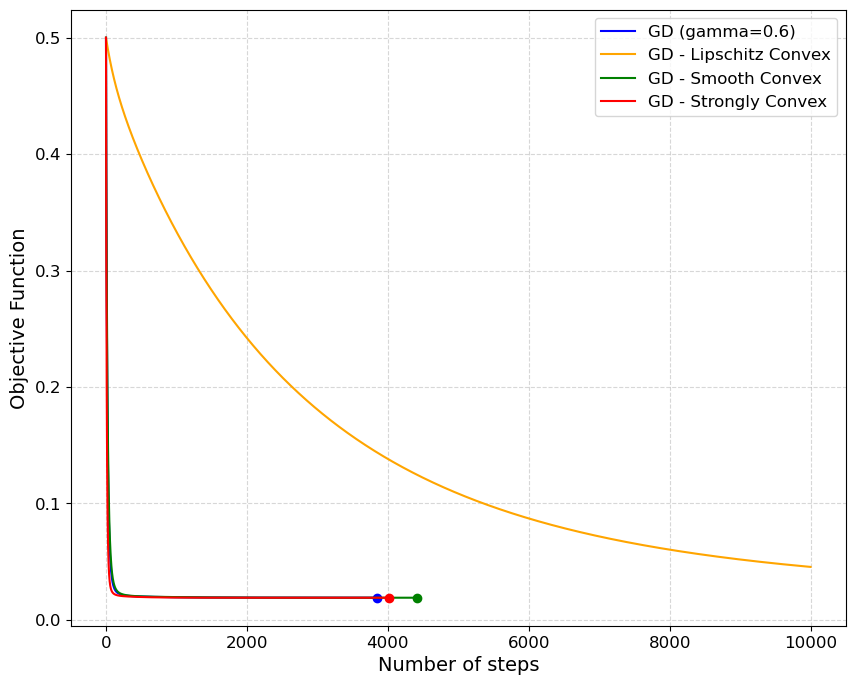

In [15]:
plt.figure(figsize=(10, 8))  
plt.xlabel('Number of steps', fontsize=14)
plt.ylabel('Objective Function', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.plot(range(len(f_gd)), f_gd, 'blue', label='GD (gamma=0.6)')
plt.plot(len(f_gd)-1, f_gd[-1], 'o', color='blue')
plt.plot(range(len(f_gd_L)), f_gd_L, 'orange', label='GD - Lipschitz Convex')
plt.plot(range(len(f_gd_S)), f_gd_S, 'green', label='GD - Smooth Convex')
plt.plot(len(f_gd_S)-1, f_gd_S[-1], 'o', color='green')
plt.plot(range(len(f_gd_SC)), f_gd_SC, 'red', label='GD - Strongly Convex')
plt.plot(len(f_gd_SC)-1, f_gd_SC[-1], 'o', color='red')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=12)
plt.show()


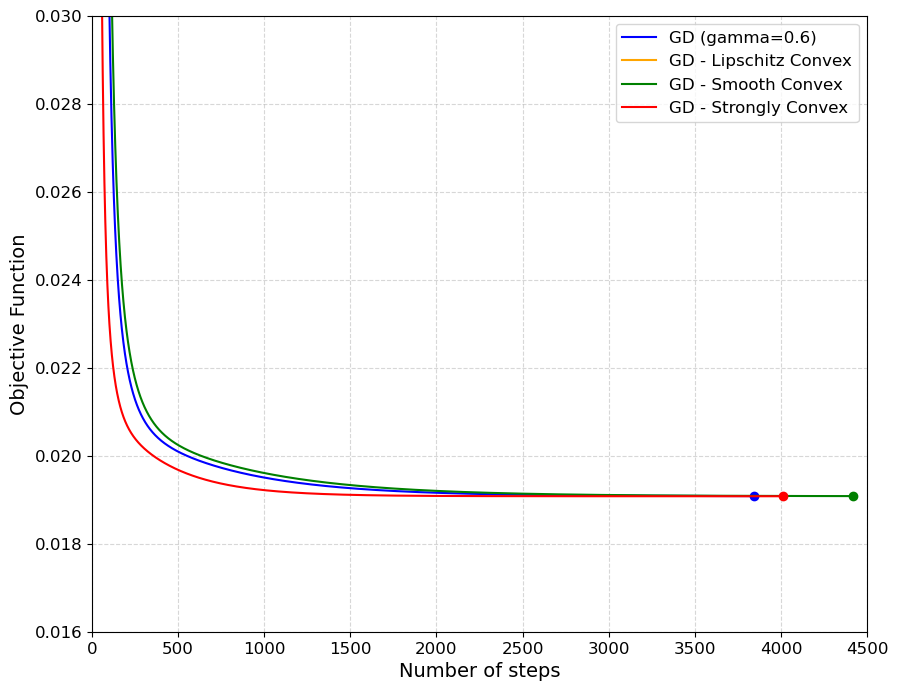

In [16]:
plt.figure(figsize=(10, 8))  
plt.xlabel('Number of steps', fontsize=14)
plt.ylabel('Objective Function', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.plot(range(len(f_gd)), f_gd, 'blue', label='GD (gamma=0.6)')
plt.plot(len(f_gd)-1, f_gd[-1], 'o', color='blue')
plt.plot(range(len(f_gd_L)), f_gd_L, 'orange', label='GD - Lipschitz Convex')
plt.plot(len(f_gd_L)-1, f_gd_L[-1], 'o', color='orange')
plt.plot(range(len(f_gd_S)), f_gd_S, 'green', label='GD - Smooth Convex')
plt.plot(len(f_gd_S)-1, f_gd_S[-1], 'o', color='green')
plt.plot(range(len(f_gd_SC)), f_gd_SC, 'red', label='GD - Strongly Convex')
plt.plot(len(f_gd_SC)-1, f_gd_SC[-1], 'o', color='red')

plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0.016, 0.03)
plt.xlim(0, 4500)

plt.legend(loc='upper right', fontsize=12)
plt.show()


---

### Stocastical Gradient Descent

#### Stochastic Gradient Descent (`sgd`)

This is the standard stochastic gradient descent algorithm, using mini-batches and epochs.

**Update Rule:**

$$
x_{t+1} := x_t - \gamma \nabla f_i(x_t)
$$

Here, $\nabla f_i(x^{(t)})$ is the gradient computed over a *mini-batch* of randomly sampled points.

**Mini-batches and Epochs:**

- Each *epoch* consists of several gradient updates.
- The number of updates per epoch is set as $\texttt{max\_iter} / \texttt{epochs}$.
- In each step, a mini-batch of size $\texttt{batch\_size}$ is selected uniformly at random *without replacement*.
- The gradient and loss are computed only on this batch, making each update much faster and noisier than full-batch GD.

The learning rate $\gamma$ is constant throughout:

$$
\gamma := \text{given value}
$$

#### Stochastic Gradient Descent with Lipschitz convex function (`sgd_lipschitz`)

This method uses the same idea and learning rate formula as in the deterministic gradient descent under Lipschitz and convex assumptions:

$$
\gamma = \frac{R}{B \sqrt{T}} 
$$

#### Stochastic Gradient Descent for strongly convex function (`sgd_strongly_convex`)

This method assumes $f$ is $\mu$-strongly convex and differentiable. The step size decays over time:

$$
\gamma_t = \frac{2}{\mu (t + 1)}
$$

Here $\mu$ is computed as:

$$
\mu = \frac{1}{n} \lambda_{\min}(X^\top X)
$$

**Note:** If $\mu \leq 0$, the function is not strongly convex and this method is invalid.


In [17]:
def stochastic_gradient_descent(
    x0,
    X,
    y,
    grad_func,
    loss_func,
    learning_rate=None,
    max_iter=max_iter,
    batch_size=1,
    tol=1e-4,
    verbose=True,
    strongly=False,
    epochs=10
):
    n = X.shape[0]
    x = x0.copy()
    x_vals = [x.copy()]
    f_vals = []
    iteration = 0

    for epoch in range(1, epochs + 1):
        iter_per_epoch = max_iter // epochs

        for step in range(1, iter_per_epoch + 1):

            idx = np.random.choice(n, batch_size, replace=False)
            X_batch = X[idx] if isinstance(X, np.ndarray) else X.iloc[idx]
            y_batch = y[idx] if isinstance(y, np.ndarray) else y.iloc[idx]

            f_curr = loss_func(x, X_batch, y_batch)
            grad = grad_func(x, X_batch, y_batch)
            grad_norm = np.linalg.norm(grad)

            f_vals.append(f_curr)

            if np.isnan(f_curr) or f_curr > 1e6:
                print("STOP - Divergence detected")
                break

            if verbose:
                full_loss = loss_func(x, X, y)
                full_grad = grad_func(x, X, y)  
                full_grad_norm = np.linalg.norm(full_grad)
                print(f"   Epoch: {epoch}/{epochs} | Step: {step}/{iter_per_epoch}")
                print_log(
                    step=(epoch - 1) * iter_per_epoch + step,
                    f_curr=full_loss,
                    grad_norm=full_grad_norm,
                    batch_loss=f_curr
                )
                

            if grad_norm < tol:
                break

            gamma = learning_rate(iteration)
            x -= gamma * grad
            iteration += 1
            x_vals.append(x.copy())

    return f_vals, x_vals


In [18]:
def sgd(x0, gamma, max_iter, X, y, batch_size, epochs):
    return stochastic_gradient_descent(
        x0=x0,
        grad_func=grad,
        loss_func=loss,
        learning_rate=lambda k: gamma,
        max_iter=max_iter,
        X=X,
        y=y,
        batch_size=batch_size,
        epochs=epochs
    )

def sgd_lipschitz(x0, max_iter, X, y, x_opt, batch_size, epochs):
    R = np.linalg.norm(x0 - x_opt)
    B = np.linalg.norm(grad(x0, X, y))  
    gamma = R / (B * np.sqrt(max_iter))
    
    return stochastic_gradient_descent(
        x0=x0,
        grad_func=grad,
        loss_func=loss,
        learning_rate=lambda k: gamma,
        max_iter=max_iter,
        X=X,
        y=y,
        batch_size=batch_size,
        epochs=epochs
    )

def sgd_strongly_convex(x0, max_iter, X, y, batch_size, t0, epochs):
    n = X.shape[0]
    H = X.T @ X
    eigvals = np.linalg.eigvalsh(H)
    mu = np.min(eigvals) / n
    print(f"[INFO] mu = {mu:.3e}")

    if mu <= 0:
        print("[X] The function is NOT STRONGLY CONVEX: µ <= 0")
        return None, None

    return stochastic_gradient_descent(
        x0=x0,
        grad_func=grad,
        loss_func=loss,
        learning_rate = lambda t: 2 / (mu * (t0 + t + 1)),
        max_iter=max_iter,
        X=X,
        y=y,
        batch_size=batch_size,
        epochs=epochs,
        strongly=True
    )



In [19]:
max_iter = 10000
gamma = 5e-2
batch_size = 32
epochs = 20

print("[TRAIN] Stochastical Gradient Descent:")
f_sgd, x_sgd = sgd(x0, gamma=gamma, max_iter=max_iter, X=X_train, y=y_train, batch_size=batch_size, epochs=epochs)

x_final = x_sgd[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] Stochastical Gradient Descent:
   Epoch: 1/20 | Step: 1/500
[STEP    1] batch loss = 0.49290 | f(x) = 0.50000 | ||grad|| = 3.10e-01
   Epoch: 1/20 | Step: 2/500
[STEP    2] batch loss = 0.56871 | f(x) = 0.49469 | ||grad|| = 2.98e-01
   Epoch: 1/20 | Step: 3/500
[STEP    3] batch loss = 0.57814 | f(x) = 0.48975 | ||grad|| = 2.88e-01
   Epoch: 1/20 | Step: 4/500
[STEP    4] batch loss = 0.62094 | f(x) = 0.48382 | ||grad|| = 2.73e-01
   Epoch: 1/20 | Step: 5/500
[STEP    5] batch loss = 0.63045 | f(x) = 0.48090 | ||grad|| = 2.73e-01
   Epoch: 1/20 | Step: 6/500
[STEP    6] batch loss = 0.60729 | f(x) = 0.47839 | ||grad|| = 2.75e-01
   Epoch: 1/20 | Step: 7/500
[STEP    7] batch loss = 0.40513 | f(x) = 0.47639 | ||grad|| = 2.79e-01
   Epoch: 1/20 | Step: 8/500
[STEP    8] batch loss = 0.33816 | f(x) = 0.47507 | ||grad|| = 2.82e-01
   Epoch: 1/20 | Step: 9/500
[STEP    9] batch loss = 0.48533 | f(x) = 0.47290 | ||grad|| = 2.82e-01
   Epoch: 1/20 | Step: 10/500
[STEP   10] batch loss

In [20]:
print("[TRAIN] Stochastical Gradient Descent Lipschitz Convex:")
f_sgd_L, x_sgd_L = sgd_lipschitz(x0, max_iter=max_iter, X=X_train, y=y_train, x_opt=x_opt, batch_size=batch_size, epochs=epochs)

x_final = x_sgd_L[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] Stochastical Gradient Descent Lipschitz Convex:
   Epoch: 1/20 | Step: 1/500
[STEP    1] batch loss = 0.41542 | f(x) = 0.50000 | ||grad|| = 3.10e-01
   Epoch: 1/20 | Step: 2/500
[STEP    2] batch loss = 0.47059 | f(x) = 0.49968 | ||grad|| = 3.10e-01
   Epoch: 1/20 | Step: 3/500
[STEP    3] batch loss = 0.51696 | f(x) = 0.49937 | ||grad|| = 3.09e-01
   Epoch: 1/20 | Step: 4/500
[STEP    4] batch loss = 0.43923 | f(x) = 0.49877 | ||grad|| = 3.08e-01
   Epoch: 1/20 | Step: 5/500
[STEP    5] batch loss = 0.46888 | f(x) = 0.49842 | ||grad|| = 3.07e-01
   Epoch: 1/20 | Step: 6/500
[STEP    6] batch loss = 0.47247 | f(x) = 0.49784 | ||grad|| = 3.06e-01
   Epoch: 1/20 | Step: 7/500
[STEP    7] batch loss = 0.65519 | f(x) = 0.49750 | ||grad|| = 3.05e-01
   Epoch: 1/20 | Step: 8/500
[STEP    8] batch loss = 0.52821 | f(x) = 0.49718 | ||grad|| = 3.05e-01
   Epoch: 1/20 | Step: 9/500
[STEP    9] batch loss = 0.42382 | f(x) = 0.49672 | ||grad|| = 3.04e-01
   Epoch: 1/20 | Step: 10/500
[STEP

In [21]:
t0 = 10000

print("[TRAIN] Stochastical Gradient Descent Strongly Convex:")
f_sgd_SC, x_sgd_SC = sgd_strongly_convex(x0,  max_iter=max_iter, X=X_train, y=y_train, batch_size=batch_size, t0=t0, epochs=epochs)

x_final = x_sgd_SC[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] Stochastical Gradient Descent Strongly Convex:
[INFO] mu = 1.391e-03
   Epoch: 1/20 | Step: 1/500
[STEP    1] batch loss = 0.53929 | f(x) = 0.50000 | ||grad|| = 3.10e-01
   Epoch: 1/20 | Step: 2/500
[STEP    2] batch loss = 0.50553 | f(x) = 0.48245 | ||grad|| = 2.66e-01
   Epoch: 1/20 | Step: 3/500
[STEP    3] batch loss = 0.56755 | f(x) = 0.47461 | ||grad|| = 2.60e-01
   Epoch: 1/20 | Step: 4/500
[STEP    4] batch loss = 0.32813 | f(x) = 0.47225 | ||grad|| = 2.84e-01


   Epoch: 1/20 | Step: 5/500
[STEP    5] batch loss = 0.67106 | f(x) = 0.46351 | ||grad|| = 2.65e-01
   Epoch: 1/20 | Step: 6/500
[STEP    6] batch loss = 0.24338 | f(x) = 0.44962 | ||grad|| = 2.31e-01
   Epoch: 1/20 | Step: 7/500
[STEP    7] batch loss = 0.44878 | f(x) = 0.44431 | ||grad|| = 2.25e-01
   Epoch: 1/20 | Step: 8/500
[STEP    8] batch loss = 0.56273 | f(x) = 0.43784 | ||grad|| = 2.13e-01
   Epoch: 1/20 | Step: 9/500
[STEP    9] batch loss = 0.47362 | f(x) = 0.43162 | ||grad|| = 2.15e-01
   Epoch: 1/20 | Step: 10/500
[STEP   10] batch loss = 0.27524 | f(x) = 0.43195 | ||grad|| = 2.45e-01
   Epoch: 1/20 | Step: 11/500
[STEP   11] batch loss = 0.39098 | f(x) = 0.42988 | ||grad|| = 2.52e-01
   Epoch: 1/20 | Step: 12/500
[STEP   12] batch loss = 0.47861 | f(x) = 0.42796 | ||grad|| = 2.61e-01
   Epoch: 1/20 | Step: 13/500
[STEP   13] batch loss = 0.24155 | f(x) = 0.42257 | ||grad|| = 2.61e-01
   Epoch: 1/20 | Step: 14/500
[STEP   14] batch loss = 0.38361 | f(x) = 0.41803 | ||gra

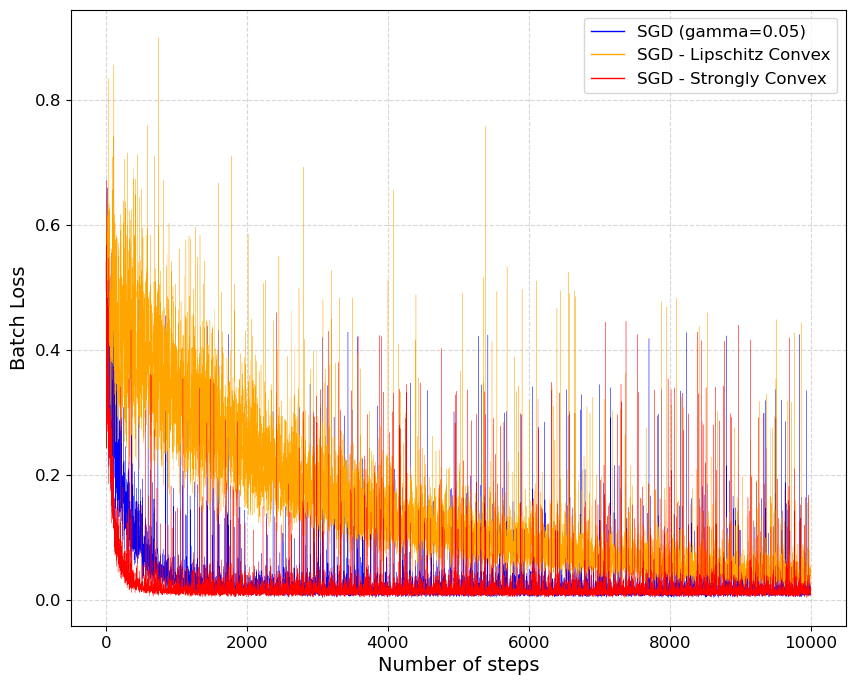

In [22]:
plt.figure(figsize=(10, 8))  
plt.xlabel('Number of steps', fontsize=14)
plt.ylabel('Batch Loss', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.plot(range(len(f_sgd)), f_sgd, 'blue', label='SGD (gamma=0.05)', linewidth=0.2)
plt.plot(range(len(f_sgd_L)), f_sgd_L, 'orange', label='SGD - Lipschitz Convex', linewidth=0.2)
plt.plot(range(len(f_sgd_SC)), f_sgd_SC, 'red', label='SGD - Strongly Convex', linewidth=0.2)

legend_handles = [
    Line2D([0], [0], color='blue', lw=1, label='SGD (gamma=0.05)'),
    Line2D([0], [0], color='orange', lw=1, label='SGD - Lipschitz Convex'),
    Line2D([0], [0], color='red', lw=1, label='SGD - Strongly Convex')
]

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(handles=legend_handles, loc='upper right', fontsize=12)

plt.show()


---

#### Adaptive Gradient Algorithm (Adagrad)

Adagrad adatta il passo di apprendimento per ogni coordinata, penalizzando le direzioni in cui il gradiente è stato storicamente grande. Questo è utile quando i dati sono sparsi o le feature hanno scale diverse.

**Aggiornamento Adagrad:**

Per ogni coordinata $i$, l'aggiornamento è dato da:

$$
[\mathbf{G}_t]_i := \sum_{s=0}^t \left( [\mathbf{g}_s]_i \right)^2
$$

$$
[\mathbf{x}_{t+1}]_i := [\mathbf{x}_t]_i - \gamma \cdot \frac{[\mathbf{g}_t]_i}{\sqrt{[\mathbf{G}_t]_i} + \varepsilon} \quad \forall i
$$

Dove:
- $\mathbf{g}_t$ è il gradiente (anche stocastico) della loss rispetto a $\mathbf{x}_t$.
- $\gamma$ è il tasso di apprendimento iniziale.
- $\varepsilon > 0$ è un termine di stabilizzazione numerica.

**Caratteristiche:**
- Il denominatore cresce nel tempo, riducendo il passo di aggiornamento.
- Può convergere rapidamente, ma rischia di "congelarsi" se i gradienti sono troppo grandi nelle prime iterazioni.

#### Adaptive Moment Estimation (Adam)

Adam combina il metodo del momentum con Adagrad. Tiene traccia sia della media (1º momento) che della varianza (2º momento) dei gradienti, correggendoli con bias correction per ottenere stime più accurate nelle prime fasi.

**Aggiornamenti Adam:**

1. **Gradiente stocastico:**

$$
\mathbf{g}_t := \nabla f(\mathbf{x}_t)
$$

2. **Momento del primo ordine (media esponenziale):**

$$
\mathbf{m}_t := \beta_1 \mathbf{m}_{t-1} + (1 - \beta_1) \mathbf{g}_t
$$

3. **Momento del secondo ordine (statistica di varianza):**

$$
[\mathbf{v}_t]_i := \beta_2 [\mathbf{v}_{t-1}]_i + (1 - \beta_2) \left([\mathbf{g}_t]_i\right)^2 \quad \forall i
$$

4. **Aggiornamento dei parametri:**

$$
[\mathbf{x}_{t+1}]_i := [\mathbf{x}_t]_i - \gamma \cdot \frac{[\hat{\mathbf{m}}_t]_i}{\sqrt{[\hat{\mathbf{v}}_t]_i} + \varepsilon} \quad \forall i
$$

dove:
- $\hat{\mathbf{m}}_t$ e $\hat{\mathbf{v}}_t$ sono le versioni bias-corrected di $\mathbf{m}_t$ e $\mathbf{v}_t$.
- $\gamma$ è il learning rate.
- $\beta_1$ e $\beta_2$ controllano la "memoria" dei momenti.

**Vantaggi:**


In [23]:
def adagrad(
    x0,
    X,
    y,
    lr=0.1,
    eps=1e-8,
    max_iter=1000,
    tol=1e-4,
    verbose=True,
    epochs=10
):
    x = x0.copy()
    G = np.zeros_like(x)
    f_vals, x_vals = [loss(x, X, y)], [x.copy()]
    iteration = 0

    for epoch in range(1, epochs + 1):
        iter_per_epoch = max_iter // epochs

        for step in range(1, iter_per_epoch + 1):
            g = grad(x, X, y)
            grad_norm = np.linalg.norm(g)
            f_curr = loss(x, X, y)

            if verbose:
                print(f"   Epoch: {epoch}/{epochs} | Step: {step}/{iter_per_epoch}")
                print_log(
                    step=(epoch - 1) * iter_per_epoch + step,
                    f_curr=f_curr,
                    grad_norm=grad_norm
                )

            if grad_norm < tol:
                return f_vals, x_vals

            G += g**2
            x -= (lr / (np.sqrt(G) + eps)) * g

            x_vals.append(x.copy())
            f_vals.append(f_curr)
            iteration += 1

    return f_vals, x_vals


In [24]:
def adam(
    x0,
    X,
    y,
    lr=0.001,
    beta1=0.9,
    beta2=0.999,
    eps=1e-8,
    max_iter=1000,
    tol=1e-4,
    verbose=True,
    epochs=10
):
    x = x0.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    f_vals, x_vals = [loss(x, X, y)], [x.copy()]
    iteration = 0

    for epoch in range(1, epochs + 1):
        iter_per_epoch = max_iter // epochs

        for step in range(1, iter_per_epoch + 1):
            g = grad(x, X, y)
            grad_norm = np.linalg.norm(g)
            f_curr = loss(x, X, y)

            if verbose:
                print(f"   Epoch: {epoch}/{epochs} | Step: {step}/{iter_per_epoch}")
                print_log(
                    step=(epoch - 1) * iter_per_epoch + step,
                    f_curr=f_curr,
                    grad_norm=grad_norm
                )

            if grad_norm < tol:
                return f_vals, x_vals

            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * (g ** 2)

            m_hat = m / (1 - beta1 ** (iteration + 1))
            v_hat = v / (1 - beta2 ** (iteration + 1))

            x -= lr * m_hat / (np.sqrt(v_hat) + eps)

            x_vals.append(x.copy())
            f_vals.append(f_curr)
            iteration += 1

    return f_vals, x_vals


In [25]:
gamma = 0.4

print("[TRAIN] Adagrad:")
f_AG, x_AG = adagrad(x0, X_train, y_train, lr=gamma, max_iter=max_iter, epochs=epochs)
x_final = x_AG[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] Adagrad:
   Epoch: 1/20 | Step: 1/500
[STEP    1] f(x) = 0.50000 | ||grad|| = 3.10e-01
   Epoch: 1/20 | Step: 2/500
[STEP    2] f(x) = 0.72197 | ||grad|| = 1.06e+00
   Epoch: 1/20 | Step: 3/500
[STEP    3] f(x) = 0.57555 | ||grad|| = 1.19e+00
   Epoch: 1/20 | Step: 4/500
[STEP    4] f(x) = 0.29119 | ||grad|| = 7.45e-01
   Epoch: 1/20 | Step: 5/500
[STEP    5] f(x) = 0.14026 | ||grad|| = 3.42e-01
   Epoch: 1/20 | Step: 6/500
[STEP    6] f(x) = 0.09360 | ||grad|| = 1.62e-01
   Epoch: 1/20 | Step: 7/500
[STEP    7] f(x) = 0.07334 | ||grad|| = 9.05e-02
   Epoch: 1/20 | Step: 8/500
[STEP    8] f(x) = 0.06107 | ||grad|| = 6.76e-02
   Epoch: 1/20 | Step: 9/500
[STEP    9] f(x) = 0.05242 | ||grad|| = 5.54e-02
   Epoch: 1/20 | Step: 10/500
[STEP   10] f(x) = 0.04598 | ||grad|| = 4.91e-02
   Epoch: 1/20 | Step: 11/500
[STEP   11] f(x) = 0.04105 | ||grad|| = 4.35e-02
   Epoch: 1/20 | Step: 12/500
[STEP   12] f(x) = 0.03722 | ||grad|| = 3.92e-02
   Epoch: 1/20 | Step: 13/500
[STEP   13] f(

In [26]:
print("[TRAIN] Adam:")
f_AD, x_AD = adam(x0, X_train, y_train, lr=gamma, max_iter=max_iter, epochs=epochs)
x_final = x_AD[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] Adam:
   Epoch: 1/20 | Step: 1/500
[STEP    1] f(x) = 0.50000 | ||grad|| = 3.10e-01
   Epoch: 1/20 | Step: 2/500
[STEP    2] f(x) = 0.72197 | ||grad|| = 1.06e+00
   Epoch: 1/20 | Step: 3/500
[STEP    3] f(x) = 0.44041 | ||grad|| = 8.99e-01
   Epoch: 1/20 | Step: 4/500
[STEP    4] f(x) = 0.25586 | ||grad|| = 6.28e-01
   Epoch: 1/20 | Step: 5/500
[STEP    5] f(x) = 0.25651 | ||grad|| = 6.38e-01
   Epoch: 1/20 | Step: 6/500
[STEP    6] f(x) = 0.28212 | ||grad|| = 7.91e-01
   Epoch: 1/20 | Step: 7/500
[STEP    7] f(x) = 0.16497 | ||grad|| = 5.15e-01
   Epoch: 1/20 | Step: 8/500
[STEP    8] f(x) = 0.13054 | ||grad|| = 2.77e-01
   Epoch: 1/20 | Step: 9/500
[STEP    9] f(x) = 0.21314 | ||grad|| = 5.51e-01
   Epoch: 1/20 | Step: 10/500
[STEP   10] f(x) = 0.22101 | ||grad|| = 5.88e-01
   Epoch: 1/20 | Step: 11/500
[STEP   11] f(x) = 0.14442 | ||grad|| = 3.79e-01
   Epoch: 1/20 | Step: 12/500
[STEP   12] f(x) = 0.10761 | ||grad|| = 2.85e-01
   Epoch: 1/20 | Step: 13/500
[STEP   13] f(x) 

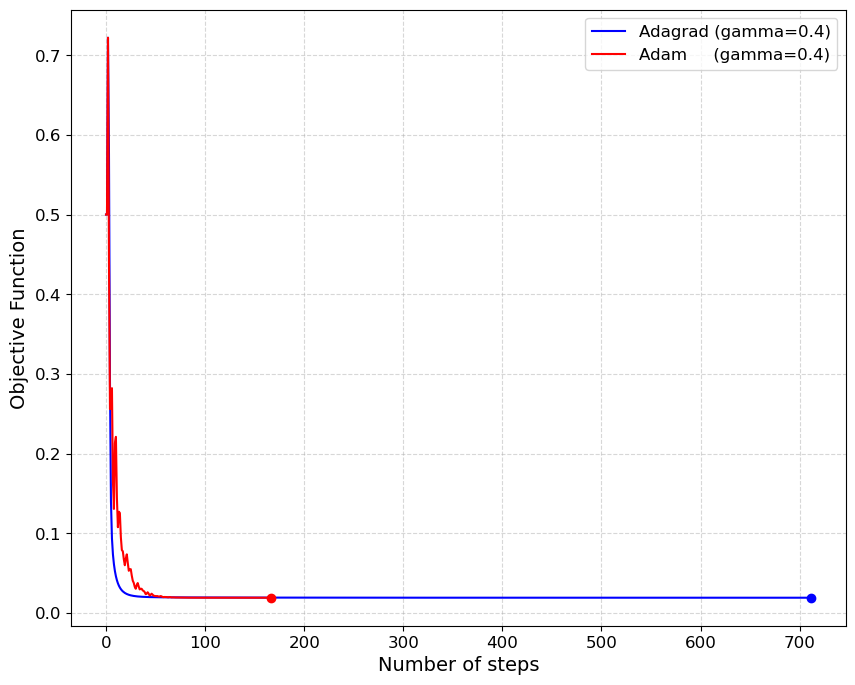

In [27]:
plt.figure(figsize=(10, 8))  
plt.xlabel('Number of steps', fontsize=14)
plt.ylabel('Objective Function', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.plot(range(len(f_AG)), f_AG, 'blue', label='Adagrad (gamma=0.4)')
plt.plot(len(f_AG)-1, f_AG[-1], 'o', color='blue')
plt.plot(range(len(f_AD)), f_AD, 'red', label='Adam     (gamma=0.4)')
plt.plot(len(f_AD)-1, f_AD[-1], 'o', color='red')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=12)
plt.show()


---

### Newton-Raphson Method

The update rule for the Newton-Raphson method in $d$-dimensions is:

$$
\mathbf{x}_{t+1} := \mathbf{x}_t - \nabla^2 f(\mathbf{x}_t)^{-1} \nabla f(\mathbf{x}_t)
$$
where:

- $\nabla f(\mathbf{x}_t)$ is the gradient vector of $f$ at $\mathbf{x}_t$,
- $\nabla^2 f(\mathbf{x}_t)$ is the Hessian matrix (second derivatives) of $f$ at $\mathbf{x}_t$.

This method uses the Hessian matrix to approximate the curvature of the function, allowing for more accurate and efficient steps toward the minimum compared to gradient descent, which uses only first-order information.

**Key property:**  
Because Newton-Raphson uses a quadratic approximation of the function, it achieves **quadratic convergence** near the optimum, often converging in just **one step** if the function is exactly quadratic.

This means that close to the minimum, the error decreases roughly as the square of the previous error, making Newton's method very fast in such cases.


In [28]:
def newton_raphson_method(
    x0, 
    X, 
    y, 
    max_iter=100, 
    tol=1e-4, 
    verbose=True
):
    x = x0.copy()
    x_vals = [x.copy()]
    f_vals = [loss(x, X, y)]

    for step in range(1, max_iter + 1):
        g = grad(x, X, y)
        H = hess(x, X, y)
        grad_norm = np.linalg.norm(g)
        f_curr = loss(x, X, y)

        if np.isnan(f_curr) or f_curr > 1e6:
            print("STOP - Divergence detected")
            break

        if verbose:
            print_log(step, f_curr, grad_norm)

        if grad_norm < tol:
            break

        try:
            delta = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            print("STOP - Hessian not invertible")
            break

        x -= delta
        x_vals.append(x.copy())
        f_vals.append(loss(x, X, y))

    return f_vals, x_vals


In [29]:
print("[TRAIN] Newton-Raphson Method:")
f_NR, x_NR = newton_raphson_method(x0, X_train, y_train, max_iter=max_iter)
x_final = x_NR[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)


[TRAIN] Newton-Raphson Method:
[STEP    1] f(x) = 0.50000 | ||grad|| = 3.10e-01
[STEP    2] f(x) = 0.01908 | ||grad|| = 5.06e-16
[TEST] R2:   0.957
[TEST] MSE:  5.105 s²
[TEST] RMSE: 2.259 s


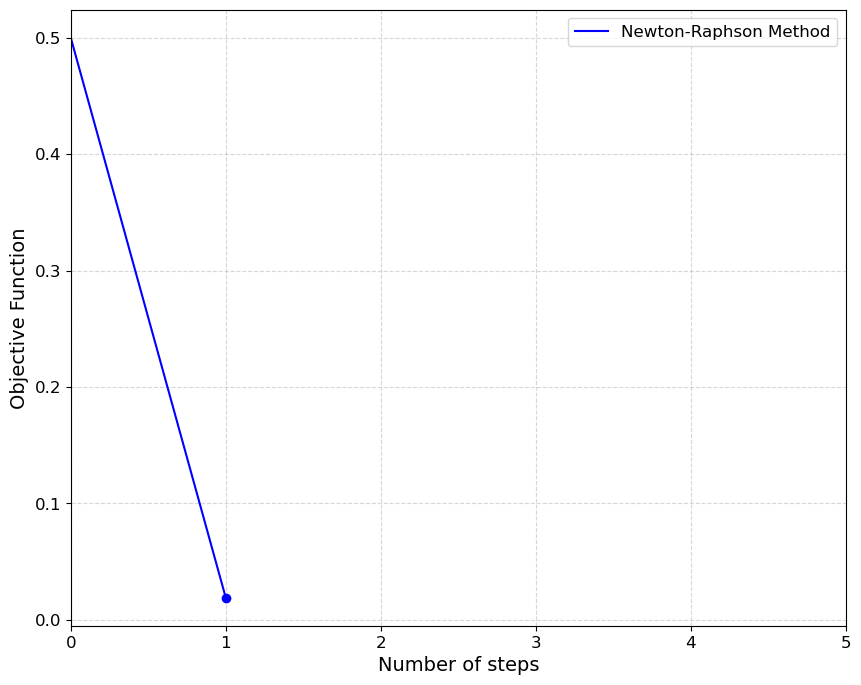

In [30]:
plt.figure(figsize=(10, 8))  
plt.xlabel('Number of steps', fontsize=14)
plt.ylabel('Objective Function', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.plot(range(len(f_NR)), f_NR, 'blue', label='Newton-Raphson Method')
plt.plot(len(f_NR)-1, f_NR[-1], 'o', color='blue')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=12)
plt.xlim(0, 5)
plt.show()

---

### Random Coordinate Gradient Descent

The update rule for the Random Coordinate Gradient Descent method selects at each iteration a random coordinate $i_t \in \{1, \ldots, d\}$ and updates only that coordinate:

$$
\mathbf{x}_{t+1} := \mathbf{x}_t - \frac{1}{L_{i_t}} \nabla_{i_t} f(\mathbf{x}_t) \mathbf{e}_{i_t}
$$

where:

- $\mathbf{e}_{i_t}$ is the unit vector with 1 at coordinate $i_t$ and 0 elsewhere,
- $\nabla_{i_t} f(\mathbf{x}_t)$ is the partial derivative of $f$ at $\mathbf{x}_t$ with respect to coordinate $i_t$,
- $L_{i_t}$ is the Lipschitz constant for the $i_t$-th coordinate gradient.

In the code, the Lipschitz constants $L_j$ for each coordinate $j$ are computed as:

$$
L_j = \frac{1}{n} \sum_{k=1}^n X_{k,j}^2
$$

where $X \in \mathbb{R}^{n \times d}$ is the data matrix with $n$ samples and $d$ features.

At each iteration, a random coordinate $j$ is selected, the gradient component along that coordinate is computed as:

$$
g_j = \frac{1}{n} \sum_{k=1}^n X_{k,j} \left( \mathbf{x}_t^\top \mathbf{X}_{k,:} - y_k \right)
$$

and the update step is:

$$
x_{t+1}^{(j)} := x_t^{(j)} - \frac{g_j}{L_j}
$$

while all other coordinates remain unchanged.


In [31]:
def random_coordinate_gradient_descent(
    x0,
    X,
    y,
    max_iter=100,
    tol=1e-4,
    verbose=True,
    seed=None
):
    np.random.seed(seed)
    x = x0.copy()
    n_samples, n_features = X.shape
    x_vals = [x.copy()]
    f_vals = [loss(x, X, y)]
    L = (1 / n_samples) * np.sum(X ** 2, axis=0)  

    for step in range(1, max_iter + 1):
        f_curr = loss(x, X, y)
        grad_full = grad(x, X, y)
        grad_norm = np.linalg.norm(grad_full)

        if np.isnan(f_curr) or f_curr > 1e6:
            print("STOP - Divergence detected")
            break

        if verbose:
            print_log(step, f_curr, grad_norm)

        if grad_norm < tol:
            break

        j = np.random.randint(n_features)

        residuals = X @ x - y
        g_j = (1 / n_samples) * np.dot(X[:, j], residuals)
        if L[j] > 0:
            x[j] -= g_j / L[j]

        x_vals.append(x.copy())
        f_vals.append(loss(x, X, y))

    return f_vals, x_vals


In [32]:
print("[TRAIN] Random Coordinate Gradient Descent:")
f_RCGD, x_RCGD = random_coordinate_gradient_descent(x0, X_train, y_train, max_iter=max_iter)
x_final = x_RCGD[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] Random Coordinate Gradient Descent:
[STEP    1] f(x) = 0.50000 | ||grad|| = 3.10e-01
[STEP    2] f(x) = 0.49404 | ||grad|| = 3.16e-01
[STEP    3] f(x) = 0.47076 | ||grad|| = 3.16e-01
[STEP    4] f(x) = 0.46671 | ||grad|| = 3.15e-01
[STEP    5] f(x) = 0.46614 | ||grad|| = 3.09e-01
[STEP    6] f(x) = 0.46409 | ||grad|| = 3.03e-01
[STEP    7] f(x) = 0.45923 | ||grad|| = 2.83e-01
[STEP    8] f(x) = 0.43362 | ||grad|| = 3.29e-01
[STEP    9] f(x) = 0.42614 | ||grad|| = 3.64e-01
[STEP   10] f(x) = 0.41592 | ||grad|| = 3.43e-01
[STEP   11] f(x) = 0.41588 | ||grad|| = 3.43e-01
[STEP   12] f(x) = 0.41576 | ||grad|| = 3.39e-01
[STEP   13] f(x) = 0.40425 | ||grad|| = 2.89e-01
[STEP   14] f(x) = 0.39885 | ||grad|| = 2.94e-01
[STEP   15] f(x) = 0.39885 | ||grad|| = 2.94e-01
[STEP   16] f(x) = 0.38545 | ||grad|| = 2.41e-01
[STEP   17] f(x) = 0.38533 | ||grad|| = 2.45e-01
[STEP   18] f(x) = 0.38037 | ||grad|| = 2.57e-01
[STEP   19] f(x) = 0.37897 | ||grad|| = 2.45e-01
[STEP   20] f(x) = 0.3777

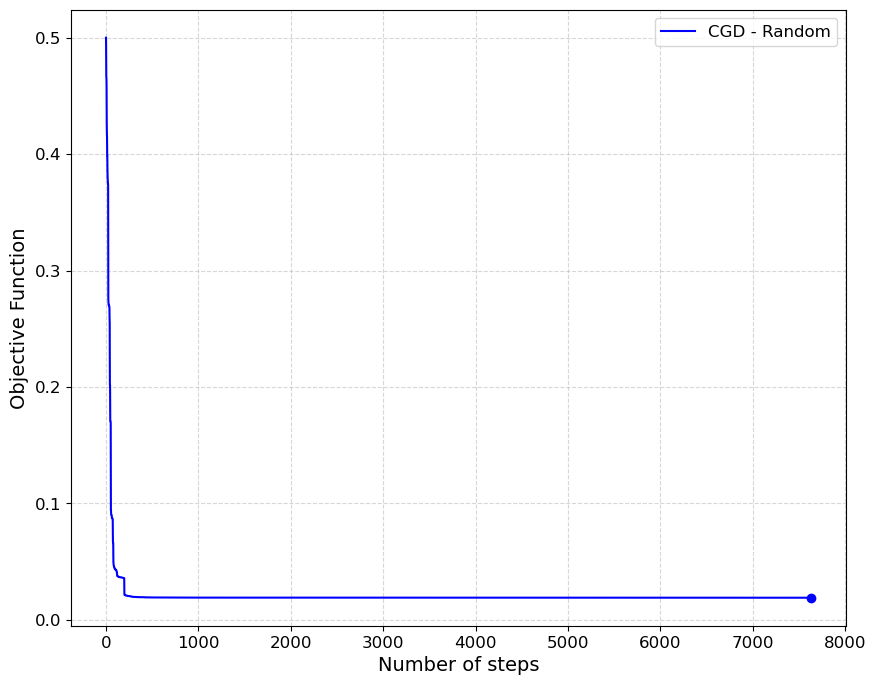

In [33]:
plt.figure(figsize=(10, 8))  
plt.xlabel('Number of steps', fontsize=14)
plt.ylabel('Objective Function', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.plot(range(len(f_RCGD)), f_RCGD, 'blue', label='CGD - Random')
plt.plot(len(f_RCGD)-1, f_RCGD[-1], 'o', color='blue')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=12)
plt.show()


---

# Proximal Gradient Descent for Ridge and Lasso Regression

## 1. Loss Functions

- **Ridge regression**:

The loss function to minimize is the sum of the mean squared error term and an $\ell_2$ penalty on the weight vector $\mathbf{w}$:

$$
f(\mathbf{w}) = \frac{1}{2n} \sum_{k=1}^n (y_k - \mathbf{x}_k^\top \mathbf{w})^2 + \lambda \sum_{j=1}^d w_j^2
$$

where
- $n$ is the number of samples,
- $\mathbf{x}_k \in \mathbb{R}^d$ is the feature vector of the $k$-th sample,
- $y_k$ is the response,
- $\lambda > 0$ is the regularization parameter controlling the strength of the penalty.

This regularization tends to **shrink the weights** and **stabilize the model**, preventing overfitting.

- **Lasso regression**:

Here the penalty is of $\ell_1$ type, i.e., the sum of the absolute values of the weights:

$$
f(\mathbf{w}) = \frac{1}{2n} \sum_{k=1}^n (y_k - \mathbf{x}_k^\top \mathbf{w})^2 + \lambda \sum_{j=1}^d |w_j|
$$

The $\ell_1$ regularization promotes **sparsity** in the vector $\mathbf{w}$, i.e., it tends to zero out many coefficients, making the model more interpretable.

### Proximal Gradient Descent 

The **Proximal Gradient Descent** algorithm optimizes functions composed of the sum of two terms:

- $g(\mathbf{x})$: a differentiable function (e.g., mean squared error),
- $h(\mathbf{x})$: a nondifferentiable or nonsmooth function (e.g., $\ell_1$ regularization).

One iteration is defined as:

$$
\mathbf{x}_{t+1} = \mathrm{prox}_{h, \gamma} \left( \mathbf{x}_t - \gamma \nabla g(\mathbf{x}_t) \right)
$$

where $\gamma > 0$ is the step size (learning rate), and the **proximal mapping** is defined as:

$$
\mathrm{prox}_{h, \gamma}(\mathbf{z}) := \arg\min_{\mathbf{y}} \left\{ \frac{1}{2 \gamma} \|\mathbf{y} - \mathbf{z}\|^2 + h(\mathbf{y}) \right\}
$$

##### Proximal functions for Ridge and Lasso

- **Ridge** ($\ell_2$ regularization):

$$
\mathrm{prox}_{\lambda \|\cdot\|^2, \gamma}(\mathbf{z}) = \frac{\mathbf{z}}{1 + 2 \gamma \lambda}
$$

- **Lasso** ($\ell_1$ regularization):

$$
\mathrm{prox}_{\lambda \|\cdot\|_1, \gamma}(\mathbf{z}) = \mathrm{sign}(\mathbf{z}) \max \left( |\mathbf{z}| - \gamma \lambda, 0 \right)
$$



In [34]:
def loss_ridge(w, X, y, lmbda):
    n = X.shape[0]
    residuals = X @ w - y
    return (1 / (2 * n)) * np.sum(residuals ** 2) + lmbda * np.sum(w**2)

def loss_lasso(w, X, y, lmbda):
    n = X.shape[0]
    residuals = X @ w - y
    return (1 / (2 * n)) * np.sum(residuals ** 2) + lmbda * np.sum(np.abs(w))

def prox_ridge(z, learning_rate, lmbda):
    return z / (1 + 2 * learning_rate * lmbda)

def prox_lasso(z, learning_rate, lmbda):
    return np.sign(z) * np.maximum(np.abs(z) - learning_rate * lmbda, 0)


In [35]:
def proximal_gradient_descent(
    x0,
    X,
    y,
    lmbda,
    max_iter=100,
    learning_rate=1e-2,
    tol=1e-4,
    method="ridge",  
    verbose=True
):
    x = x0.copy()
    x_vals = [x.copy()]

    if method == "ridge":
        loss_fn = loss_ridge
        prox_fn = prox_ridge
    elif method == "lasso":
        loss_fn = loss_lasso
        prox_fn = prox_lasso
    else:
        raise ValueError("Error")

    f_vals = [loss_fn(x, X, y, lmbda)]

    for step in range(1, max_iter + 1):
        g = grad(x, X, y)
        x_new = prox_fn(x - learning_rate * g, learning_rate, lmbda)

        f_curr = loss_fn(x_new, X, y, lmbda)
        grad_norm = np.linalg.norm(x_new - x) / max(1e-8, np.linalg.norm(x))

        if np.isnan(f_curr) or f_curr > 1e6:
            print("STOP - Divergence detected")
            break

        if verbose:
            print_log(step, f_curr, grad_norm)

        if grad_norm < tol:
            break

        x = x_new
        x_vals.append(x.copy())
        f_vals.append(f_curr)

    return f_vals, x_vals


In [36]:
def find_best_lambda(x0, X_train, y_train, X_test, y_test, 
                     mu_y=mu_y, std_y=std_y,
                     lmbda_min=0.01, lmbda_max=1.0, num_lambdas=10, 
                     method="ridge", max_iter=100, learning_rate=1e-2):
    best_lambda = None
    best_rmse = float("inf")
    best_x = None

    lmbda_vals = np.linspace(lmbda_min, lmbda_max, num_lambdas)
    for lmbda in lmbda_vals:
        print(f"\n[TRAIN] Lambda = {lmbda:.3e}")
        f_vals, x_vals = proximal_gradient_descent(
            x0, X_train, y_train,
            lmbda=lmbda,
            method=method,
            max_iter=max_iter,
            learning_rate=learning_rate,
            verbose=False
        )
        x_final = x_vals[-1]
        
        y_pred = X_test @ x_final
        y_pred_denorm = y_pred * std_y + mu_y
        y_true_denorm = y_test * std_y + mu_y

        rmse = root_mean_squared_error(y_true_denorm, y_pred_denorm)

        get_results(X_test, y_test, x_final, mu_y, std_y)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_lambda = lmbda
            best_x = x_final.copy()

    print(f"\n[FINAL RESULTS] Best lambda = {best_lambda:.3e}")
    get_results(X_test, y_test, best_x, mu_y, std_y)

    return best_lambda, best_x


In [37]:
gamma = 1
lambda_min=1e-5
lambda_max=1e0
lambdas=20

print("[TRAIN] Proximal Gradient Descent for Ridge function:")
best_lambda_ridge, best_x_ridge = find_best_lambda(x0, X_train, y_train, X_test, y_test, lmbda_min=lambda_min, lmbda_max=lambda_max, num_lambdas=lambdas, method="ridge", max_iter=max_iter, learning_rate=gamma)

[TRAIN] Proximal Gradient Descent for Ridge function:

[TRAIN] Lambda = 1.000e-05
[TEST] R2:   0.956
[TEST] MSE:  5.134 s²
[TEST] RMSE: 2.266 s

[TRAIN] Lambda = 5.264e-02
[TEST] R2:   0.500
[TEST] MSE:  58.753 s²
[TEST] RMSE: 7.665 s

[TRAIN] Lambda = 1.053e-01
[TEST] R2:   0.338
[TEST] MSE:  77.755 s²
[TEST] RMSE: 8.818 s

[TRAIN] Lambda = 1.579e-01
[TEST] R2:   0.261
[TEST] MSE:  86.849 s²
[TEST] RMSE: 9.319 s

[TRAIN] Lambda = 2.105e-01
[TEST] R2:   0.215
[TEST] MSE:  92.231 s²
[TEST] RMSE: 9.604 s

[TRAIN] Lambda = 2.632e-01
[TEST] R2:   0.184
[TEST] MSE:  95.823 s²
[TEST] RMSE: 9.789 s

[TRAIN] Lambda = 3.158e-01
[TEST] R2:   0.162
[TEST] MSE:  98.411 s²
[TEST] RMSE: 9.920 s

[TRAIN] Lambda = 3.684e-01
[TEST] R2:   0.145
[TEST] MSE:  100.377 s²
[TEST] RMSE: 10.019 s

[TRAIN] Lambda = 4.211e-01
[TEST] R2:   0.132
[TEST] MSE:  101.930 s²
[TEST] RMSE: 10.096 s

[TRAIN] Lambda = 4.737e-01
[TEST] R2:   0.121
[TEST] MSE:  103.193 s²
[TEST] RMSE: 10.158 s

[TRAIN] Lambda = 5.263e-01
[TE

---

In [38]:
event_categories = categories_dict[0]
team_categories = categories_dict[1]
compound_categories = categories_dict[2]
fresh_tyre_categories = categories_dict[3]
rainfall_categories = categories_dict[4]

event_feature_names = [f"Track name [{cat}]" for cat in event_categories]
team_feature_names = [f"Team name [{cat}]" for cat in team_categories]
compound_feature_names = [f"Compound [{cat}]" for cat in compound_categories]
fresh_tyre_feature_names = [f"Fresh tyre [{cat}]" for cat in fresh_tyre_categories]
rainfall_feature_names = [f"Rainfall [{cat}]" for cat in rainfall_categories]

num_keys = ['TyreLife', 'TrackTemp', 'WindDirection', 'WindSpeed', 'FuelLevel']
num_feature_names = [variables[k] for k in num_keys]

feature_names = (
    ["bias"] +
    event_feature_names +
    team_feature_names +
    compound_feature_names +
    fresh_tyre_feature_names +
    rainfall_feature_names +
    num_feature_names
)

coeff_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": best_x_ridge
})

def style_coeff(val, tol=1e-6):
    if abs(val) < tol:
        color = 'color: grey'
    else:
        color = 'color: red' if val > 0 else 'color: green'
    return f'{color}; font-weight: bold'


coeff_df_styled = (
    coeff_df.style
    .format({'Coefficient': '{:.3f}'})
    .map(style_coeff, subset=['Coefficient'])
)

coeff_df_styled


For each categorical variable (e.g., "Track name"):

- Select the coefficients corresponding to its dummy variables.
- Compute the **root mean square (RMS)** of the coefficients:

$$
\text{RMS} = \sqrt{\frac{1}{m} \sum_{j=1}^m c_j^2}
$$

where $c_j$ are the dummy coefficients for the variable and $m$ is the number of dummy variables.

- This RMS value represents an aggregated measure of the overall importance of the categorical variable.

If no dummy variables exist (e.g., variable absent), importance is set to zero.

For each numerical variable:

- Take the absolute value of its coefficient (if present).
- This value represents the direct importance of the numerical feature.



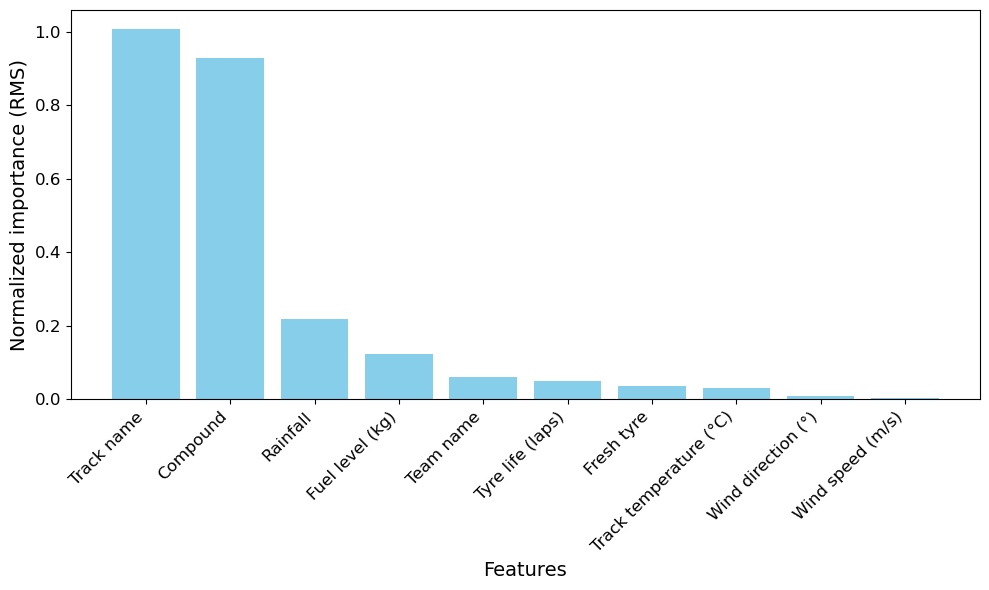

In [39]:
categorical_vars = {
    "Track name": event_feature_names,
    "Team name": team_feature_names,
    "Compound": compound_feature_names,
    "Fresh tyre": fresh_tyre_feature_names,
    "Rainfall": rainfall_feature_names
}

def plot_shrinkage(x_final): 

    coeff_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": x_final
    })

    coeff_df = coeff_df[coeff_df['Feature'] != 'bias']

    importance = {}

    for var_name, dummy_features in categorical_vars.items():
        coeffs = coeff_df.loc[coeff_df['Feature'].isin(dummy_features), 'Coefficient'].values
        if len(coeffs) > 0:
            rms = np.sqrt(np.sum(coeffs**2) / len(coeffs))  
            importance[var_name] = rms
        else:
            importance[var_name] = 0

    for num_var in num_feature_names:
        coeff = coeff_df.loc[coeff_df['Feature'] == num_var, 'Coefficient'].values
        if len(coeff) > 0:
            importance[num_var] = abs(coeff[0])
        else:
            importance[num_var] = 0

    importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))

    plt.figure(figsize=(10, 6))
    plt.bar(importance.keys(), importance.values(), color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Normalized importance (RMS)', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.show()

plot_shrinkage(x_final)

In [40]:
gamma = 1
lambda_min=5e-3
lambda_max=1e0
lambdas=20

print("[TRAIN] Proximal Gradient Descent for Lasso function:")
best_lambda_ridge, best_x_lasso = find_best_lambda(x0, X_train, y_train, X_test, y_test, lmbda_min=lambda_min, lmbda_max=lambda_max, num_lambdas=lambdas, method="lasso", max_iter=max_iter, learning_rate=gamma)

[TRAIN] Proximal Gradient Descent for Lasso function:

[TRAIN] Lambda = 5.000e-03
[TEST] R2:   0.927
[TEST] MSE:  8.547 s²
[TEST] RMSE: 2.924 s

[TRAIN] Lambda = 5.737e-02
[TEST] R2:   0.257
[TEST] MSE:  87.223 s²
[TEST] RMSE: 9.339 s

[TRAIN] Lambda = 1.097e-01
[TEST] R2:   0.016
[TEST] MSE:  115.559 s²
[TEST] RMSE: 10.750 s

[TRAIN] Lambda = 1.621e-01
[TEST] R2:   0.002
[TEST] MSE:  117.203 s²
[TEST] RMSE: 10.826 s

[TRAIN] Lambda = 2.145e-01
[TEST] R2:   -0.000
[TEST] MSE:  117.452 s²
[TEST] RMSE: 10.838 s

[TRAIN] Lambda = 2.668e-01
[TEST] R2:   -0.000
[TEST] MSE:  117.452 s²
[TEST] RMSE: 10.838 s

[TRAIN] Lambda = 3.192e-01
[TEST] R2:   -0.000
[TEST] MSE:  117.452 s²
[TEST] RMSE: 10.838 s

[TRAIN] Lambda = 3.716e-01
[TEST] R2:   -0.000
[TEST] MSE:  117.452 s²
[TEST] RMSE: 10.838 s

[TRAIN] Lambda = 4.239e-01
[TEST] R2:   -0.000
[TEST] MSE:  117.452 s²
[TEST] RMSE: 10.838 s

[TRAIN] Lambda = 4.763e-01
[TEST] R2:   -0.000
[TEST] MSE:  117.452 s²
[TEST] RMSE: 10.838 s

[TRAIN] Lambda

In [41]:
coeff_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": best_x_lasso
})

row_styles = [
    {'selector': f'tbody tr:nth-child({i+1})', 'props': [('opacity', '0.4')]}
    for i, val in enumerate(coeff_df['Coefficient'])
    if val == 0
]

coeff_df_styled = (
    coeff_df.style
    .format({'Coefficient': '{:.3f}'})
    .map(style_coeff, subset=['Coefficient'])
    .set_table_styles(row_styles)
)

coeff_df_styled

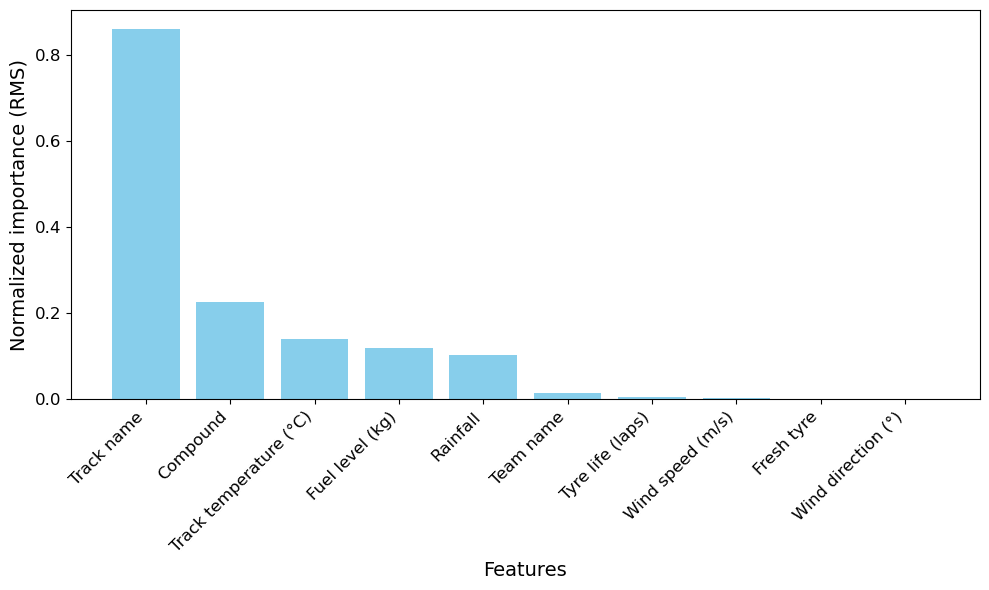

In [42]:
plot_shrinkage(best_x_lasso)